In [1]:
import pandas as pd
import numpy as np
from numpy import nanmean

from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import pickle
import re
def add_comma(match):
    return match.group(0) + ','

# plots
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from functions import getResponses, chooseData, chooseEmb, getEmbeddings, getData, predModel, corrUserBased # general auxiliary function
from functions import predictionPerformance # human judges comparison 2
from functions import regCorr, mean_confidence_interval, pearsonr_ci, welch_t_test # human judges comparison 1

# warning messages
import warnings
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")

## Chatgpt Functions

In [376]:
import os
import openai

# connect to OpenAI and define chatgpt_prediction
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_key = ""


def chatgpt_prediction_method1(train_items_texts, train_items_responses, test_items_texts):
    
    fold_predictions = []
    for i in range(len(test_items_texts)):

        # training text
        prompt_training_data = ""
        for j in range(len(train_items_texts)):
            prompt_training_data += " - {}: {} \n".format(train_items_texts[j], train_items_responses[j])

        # testing text
        prompt_testing_data = " - {}: ".format(test_items_texts[i])


        # final prompt
        prompt_template = "You are a response predictor. You will be provided with responses of a participant for a list of psychology measuring items. You will use these information to predict their response for a new item. Your prediction must be from the range of 1 to 5.\n\n \
        You are provided with the participant\'s responses to a list of items:\n \
        {} \
        You will predict this participant\'s response to the following item. Just response with one number. \
        {} \
        ".format(prompt_training_data, prompt_testing_data)
        # print(prompt_template)
        # put to gpt for prediction
        # response = "{5}"
        response = openai.ChatCompletion.create(
             model="gpt-3.5-turbo",
             messages=[{"role": "user", "content": prompt_template}]
           )
        response_text = int(response['choices'][0]['message']['content'])
        # print(response)
        
        # extract prediction and put to final results
        extracted_prediction = response_text
        fold_predictions.append(extracted_prediction)
        
    return fold_predictions


def chatgpt_prediction_method2(train_items_texts, train_items_responses, test_items_texts):
    
    fold_predictions = []

    # training text
    prompt_training_data = ""
    for j in range(len(train_items_texts)):
        prompt_training_data += " - {}: {} \n".format(train_items_texts[j], train_items_responses[j])

    # training text
    prompt_testing_data = ""
    for j in range(len(test_items_texts)):
        prompt_testing_data += " - {} \n".format(test_items_texts[j])

    # final prompt
    prompt_template = "You are a response predictor. You will be provided with responses of a participant for a list of psychology measuring items. You will use these information to predict their response for a new item. Your prediction must be from the range of 1 to 5.\n\n \
    You are provided with the participant\'s responses to a list of items:\n \
    {} \
    You will predict this participant\'s response to the following item. You will rewrite each item followed by a colon and then the prediction.   \
    {} \
    ".format(prompt_training_data, prompt_testing_data)
    # print(prompt_template)
    # put to gpt for prediction
    # response = "{5}"
    tries = 5
    for t in range(tries):
        try:
            response = openai.ChatCompletion.create(
                 model="gpt-3.5-turbo",
                 messages=[{"role": "user", "content": prompt_template}],
                 temperature = 0.6
               )        
        except:
            if t < tries - 1: # t is zero indexed
                import time
                time.sleep(20)
                print("Error happens!")
                continue
            else:
                raise
        break
    response_text = response['choices'][0]['message']['content']
    # print(response_text)

    # extract prediction and put to final results
    # extracted_prediction = response_text
    # fold_predictions.append(extracted_prediction)
    
    fold_predictions = [int(item[1]) for item in response_text.split(":")[1:]]
    # print("fold_predictions: " + str(fold_predictions))
        
    return fold_predictions

ModuleNotFoundError: No module named 'openai'

Run chatgpt predictions

In [ ]:
# data structure
# variables: groundtruth, predictions
# as a dictionary:
#  - target_number
#    - fold
#      - train/test
#        - question
# example: 
#  - predictions[target number][fold number][train or test][question id]
#  - predictions['Field 52'][5]['train']['q15']

#Choose Data Set:
d = "16pf"      #BIG5. 16PF, RIASEC, HSQ, IPIP
dir_path = "../human_studies/" + d.upper() + "/" + d.lower()
fold_path = dir_path + "_question_folds.csv"
data_path = dir_path + "_full_targets_questions.csv"

# get folds questions ids
folds = dict()
for i in range(1,11):
    folds[i] = dict()
    train_fold_path = dir_path + "_train_fold_{}.csv".format(str(i))
    test_fold_path = dir_path + "_test_fold_{}.csv".format(str(i))
    train_fold_df = pd.read_csv(train_fold_path, header=0, index_col=None)
    test_fold_df = pd.read_csv(test_fold_path, header=0, index_col=None)
    folds[i]['train_items_ids'] = train_fold_df['question-id']
    folds[i]['test_items_ids'] = test_fold_df['question-id']

ref_data = pd.read_csv(data_path, index_col=0, header=0)

groundtruth = dict()
predictions = dict()
for target in ref_data.columns[1:]:
    print("Target: {}".format(target))
    groundtruth[target] = dict()
    predictions[target] = dict()
    for fold_nr in folds.keys():
        train_items_ids = folds[fold_nr]['train_items_ids']
        test_items_ids = folds[fold_nr]['test_items_ids']
        
        # config groundtruth variables
        groundtruth[target][fold_nr] = dict()
        groundtruth[target][fold_nr]['train'] = ref_data[target].loc[train_items_ids].values
        groundtruth[target][fold_nr]['train'] = [int(item) for item in groundtruth[target][fold_nr]['train']]
        groundtruth[target][fold_nr]['test'] = ref_data[target].loc[test_items_ids].values
        groundtruth[target][fold_nr]['test'] = [int(item) for item in groundtruth[target][fold_nr]['test']]
        fold_groundtruths = groundtruth[target][fold_nr]['test']
        
        # run prediction with ChatGPT
        train_items_texts = [ref_data['full_item'].loc[q_id] for q_id in train_items_ids]
        train_items_responses = [int(ref_data[target].loc[q_id]) for q_id in train_items_ids]
        test_items_texts = [ref_data['full_item'].loc[q_id] for q_id in test_items_ids]
        fold_predictions = []
        # fold_predictions = chatgpt_prediction_method1(train_items_texts, train_items_responses, test_items_texts)
        fold_predictions = chatgpt_prediction_method2(train_items_texts, train_items_responses, test_items_texts)
        print("========")
        print("fold_predictions: " + str(fold_predictions))
        print("fold_groundtruths: " + str(fold_groundtruths))
        
        # config predictions variables
        predictions[target][fold_nr] = dict()
        predictions[target][fold_nr]['train'] = ref_data[target].loc[train_items_ids].values
        predictions[target][fold_nr]['test'] = fold_predictions
    # if len(predictions)==10:
    #    break

Target: Field 2
Target: Field 3
Target: Field 4
Target: Field 5
Target: Field 6
Target: Field 7
Target: Field 8
Target: Field 9
Target: Field 10
Target: Field 11
Target: Field 12
Target: Field 13
Target: Field 14
Target: Field 15
Target: Field 16
Target: Field 17
Target: Field 18
Target: Field 19
Target: Field 20
Target: Field 21
Target: Field 22
Target: Field 23
Target: Field 24
Target: Field 25
Target: Field 26
Target: Field 27
Target: Field 28
Target: Field 29
Target: Field 30
Target: Field 31
Target: Field 32
Target: Field 33
Target: Field 34
Target: Field 35
Target: Field 36
Target: Field 37
Target: Field 38
Target: Field 39
Target: Field 40
Target: Field 41
Target: Field 42
Target: Field 43
Target: Field 44
Target: Field 45
Target: Field 46
Target: Field 47
Target: Field 48
Target: Field 49
Target: Field 50
Target: Field 51
Target: Field 52
Target: Field 53
Target: Field 54
Target: Field 55
Target: Field 56
Target: Field 57
Target: Field 58
Target: Field 59
Target: Field 60
Targe

Save results

In [415]:
# data structure
# variables: groundtruth, predictions
# as a dictionary:
#  - target_number
#    - fold
#      - train/test
#        - question
# example: 
#  - predictions[target number][fold number][train or test][question id]
#  - predictions['Field 52'][5]['train']['q15']

import pickle
file = open(dir_path + '_chatgpt_prediction.pkl', 'wb')
pickle.dump([predictions, groundtruth], file)
file.close()

## Evaluate results

### Evaluation Functions

In [18]:
def comparePerformance(datasets, dataset_names, df_comparisons):
    for d, name in zip(datasets, dataset_names): #process all datasets in row
        #Choose Data Set:
        dir_path = "../human_studies/" + d.upper() + "/" + d.lower()
        fold_path = dir_path + "_question_folds.csv"
        data_path = dir_path + "_full_targets_questions.csv"

        #load path and necessary variables:
        folder, data = chooseData(d)        
        embeddings, save = chooseEmb(e)     #LIWC, WORD2VEC, SENTENCEBERT
        savePath = "../results/"+folder+"nonReversed/"

        #get embeddings name:
        embName = embeddings.split("_")[2].split(".")[0]

        # get predicted responses of chosen model:
        total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
        total_preds.index = total_preds.index.map(str)
        total_preds = total_preds.astype(float)

        # load target responses (original data)
        targets_data = pd.read_csv(dir_path + "_targets_data.csv", index_col=0)
        targets_data.index = targets_data.index.map(str)

        # rename questions by order (e.g., "q1")
        new_cols_names = ["q" + str(x) for x in range(1, len(targets_data.columns[4:])+1)] 
        rename_cols_dict = {k:v for k,v in zip(targets_data.columns[4:].tolist(), new_cols_names)}
        targets_data.rename(columns=rename_cols_dict, inplace=True)  

        # load human rater data (revised human study)
        human_data = pd.read_csv(dir_path + "_qualtrics_cleaned.csv", index_col = 0)
        # load model predictions (original prediction model)
        model_data = total_preds.loc[targets_data.index]
        model_data = pd.merge(model_data, targets_data.target_nr, left_index=True, right_index=True) # add target_nr

        # rename questions by order (e.g., "q1")
        model_data.rename(columns=rename_cols_dict, inplace=True)  

        df_folds = pd.read_csv(dir_path + "_question_folds.csv") # save to files
        df_folds.test_items = df_folds.test_items.apply(lambda x: re.sub(r'\[[0-9\.\s]+\]', add_comma, x)).apply(lambda x: re.sub(r'([0-9\.]+)', add_comma, x)).apply(lambda x: np.array(eval(x)[0]))
        df_folds.train_items = df_folds.train_items.apply(lambda x: re.sub(r'\[[0-9\.\s]+\]', add_comma, x)).apply(lambda x: re.sub(r'([0-9\.]+)', add_comma, x)).apply(lambda x: np.array(eval(x)[0]))

        df_comparison = predictionPerformance(targets_data, human_data, model_data, df_folds)

        ################# GPT performance

        #chatgpt results
        file = open(dir_path + "_chatgpt.pkl",'rb')
        [predictions, groundtruth] = pickle.load(file)
        file.close()

        ref_data = pd.read_csv(data_path, index_col=0, header=0)

        # get folds questions ids
        folds = dict()
        for i in range(1,11):
            folds[i] = dict()
            train_fold_path = dir_path + "_train_fold_{}.csv".format(str(i))
            test_fold_path = dir_path + "_test_fold_{}.csv".format(str(i))
            train_fold_df = pd.read_csv(train_fold_path, header=0, index_col=None)
            test_fold_df = pd.read_csv(test_fold_path, header=0, index_col=None)
            folds[i]['train_items_ids'] = train_fold_df['question-id']
            folds[i]['test_items_ids'] = test_fold_df['question-id']

        # calculate correlations for each target
        rows = []
        for i, target in enumerate(ref_data.columns[1:]):
            # print("Target {}:".format(target))
            fold_corrs = []
            for fold in folds.keys():
                # print("Fold {}:".format(fold))
                target_groundtruth = groundtruth[target][fold]['test']
                target_groundtruth = [int(item) for item in target_groundtruth]
                gpt_predictions = predictions[target][fold]['test']
                gpt_predictions = [int(item) for item in gpt_predictions]
                corr, p_val = pearsonr(target_groundtruth, gpt_predictions)
                fold_corrs.append(corr)
                rows.append([target, fold, corr, p_val, "GPT"])

        df_gpt = pd.DataFrame(rows, columns=["target", "fold", "Correlation", "pvalue", "Predictor"])
        df_gpt.target = df_gpt.target.apply(lambda x: int(re.findall(r'\d+', x)[0])) #convert targets to integers

        ########## get human data
        # load and reformat information on train/test-folds
        df_folds = pd.read_csv(dir_path + "_question_folds.csv") # save to files
        df_folds.test_items = df_folds.test_items.apply(lambda x: re.sub(r'\[[0-9\.\s]+\]', add_comma, x)).apply(lambda x: re.sub(r'([0-9\.]+)', add_comma, x)).apply(lambda x: np.array(eval(x)[0]))
        df_folds.train_items = df_folds.train_items.apply(lambda x: re.sub(r'\[[0-9\.\s]+\]', add_comma, x)).apply(lambda x: re.sub(r'([0-9\.]+)', add_comma, x)).apply(lambda x: np.array(eval(x)[0]))

        # merge performance data (model, humans, gpt)
        df_comparison = pd.concat([df_comparison, df_gpt], ignore_index=True)
        df_comparison["Dataset"] = name
        df_comparisons.append(df_comparison)
    
    return df_comparisons

## Import Data

In [20]:
# #best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par)

# lists to save the results across datasets (for plotting)
df_comparisons = []

datasets = ["big5", "16pf", "riasec", "hsq"]
dataset_names = ["NEO-PI-R", "16PF", "RIASEC", "HSQ"]
df_comparisons = comparePerformance(datasets, dataset_names, df_comparisons)

## Create Plots

Compare performances across all targets + statistical tests

In [59]:
for df_comparison in df_comparisons: #check order
    
    print("Dataset: " + df_comparison.Dataset[0])
    #humans
    h = df_comparison.loc[df_comparison.Predictor == "Human", "Correlation"].values
    ttest_h = stats.ttest_1samp(h, 0, nan_policy="omit")
    t_h = round(ttest_h[0], 3)
    p_h = round(ttest_h[1], 4)

    #model
    m = df_comparison.loc[df_comparison.Predictor == "Model", "Correlation"].values
    ttest_m = stats.ttest_1samp(m, 0, nan_policy="omit")
    t_m = round(ttest_m[0], 3)
    p_m = round(ttest_m[1], 4)

    #gpt 
    g = df_comparison.loc[df_comparison.Predictor == "GPT", "Correlation"].values
    ttest_g = stats.ttest_1samp(g, 0, nan_policy="omit")
    t_g = round(ttest_g[0], 3)
    p_g = round(ttest_g[1], 4)

    print("Human raters performance across all targets:")
    print("Correlation, t-statistic, p-value, DOF")
    print([round(nanmean(h),3), t_h, p_h, len(h)-2])

    print("\nModel performance across all targets:")
    print("Correlation, t-statistic, p-value, DOF")
    print([round(nanmean(m),3), t_m, p_m, len(m)-2])

    print("\nChatGPT performance across all targets:")
    print("Correlation, t-statistic, p-value, DOF")
    print([round(nanmean(g),3), t_g, p_g, len(g)-2])

    model = df_comparison[df_comparison.Predictor == "Model"].dropna()
    humans = df_comparison[df_comparison.Predictor == "Human"].dropna()
    gpt = df_comparison[df_comparison.Predictor == "GPT"].dropna()
    
    df = df_comparison.loc[:, ["target", "Predictor", "Correlation"]] .groupby(["target", "Predictor"], as_index=False).aggregate("mean")
    df_scatter = df.pivot(index="target", columns='Predictor', values='Correlation').rename_axis(None, axis=1).reset_index()
    df_pearsonr = df_scatter.dropna(subset = ["Human", "GPT"])
    corr_gpt = pearsonr(df_pearsonr.Human, df_pearsonr.GPT)[0:2]
    corr_model = pearsonr(df_pearsonr.Human, df_pearsonr.Model)[0:2]
    print("\nCorrelation of Human and chatGPT data: {:.3f}, pvalue:{:.3f}".format(corr_gpt[0], corr_gpt[1]))
    print("Correlation of Human and Model data: {:.3f}, pvalue:{:.3f}".format(corr_model[0], corr_model[1]))
    
    # Anova
    anova = stats.f_oneway(humans.Correlation, model.Correlation, gpt.Correlation) #is there a significant difference between the three predictors?
    print("\nOneway Anova: ")
    print("f-statistic, p-value")
    print([round(anova[0],3), round(anova[1],3)])

    #post-hoc test
    df_res = df_comparison.dropna()
    res = pairwise_tukeyhsd(df_res.Correlation, df_res.Predictor)
    print("\n")
    print(res)


    # percentage of positive significant correlations: -> very similar and very positive
    pos_cor_h = round(np.mean(df_comparison.Correlation[df_comparison.Predictor == "Human"]>0),3)*100 # 89% positive
    pos_cor_m = round(np.mean(df_comparison.Correlation[df_comparison.Predictor == "Model"]>0), 3)*100 # 91% positive 
    pos_cor_g = round(np.mean(df_comparison.Correlation[df_comparison.Predictor == "GPT"]>0), 3)*100 # 91% positive 
    print("\nModel: " + str(pos_cor_m) + "% significant positive correlations.")
    print("Humans: " + str(pos_cor_h) + "% significant positive correlations.")
    print("GPT: " + str(pos_cor_g) + "% significant positive correlations.")
    
    print("\n--------------------------------------------\n")

Dataset: NEO-PI-R
Human raters performance across all targets:
Correlation, t-statistic, p-value, DOF
[0.49, 36.375, 0.0, 598]

Model performance across all targets:
Correlation, t-statistic, p-value, DOF
[0.47, 38.393, 0.0, 598]

ChatGPT performance across all targets:
Correlation, t-statistic, p-value, DOF
[0.577, 54.192, 0.0, 598]

Correlation of Human and chatGPT data: 0.848, pvalue:0.000
Correlation of Human and Model data: 0.760, pvalue:0.000

Oneway Anova: 
f-statistic, p-value
[21.973, 0.0]


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   GPT  Human  -0.0875    0.0 -0.1279 -0.0471   True
   GPT  Model  -0.1071    0.0 -0.1474 -0.0667   True
 Human  Model  -0.0196 0.4915   -0.06  0.0208  False
----------------------------------------------------

Model: 91.3% significant positive correlations.
Humans: 89.5% significant positive correlations.
GPT: 96.5% significant po

### Barplots (average performance across all targets)

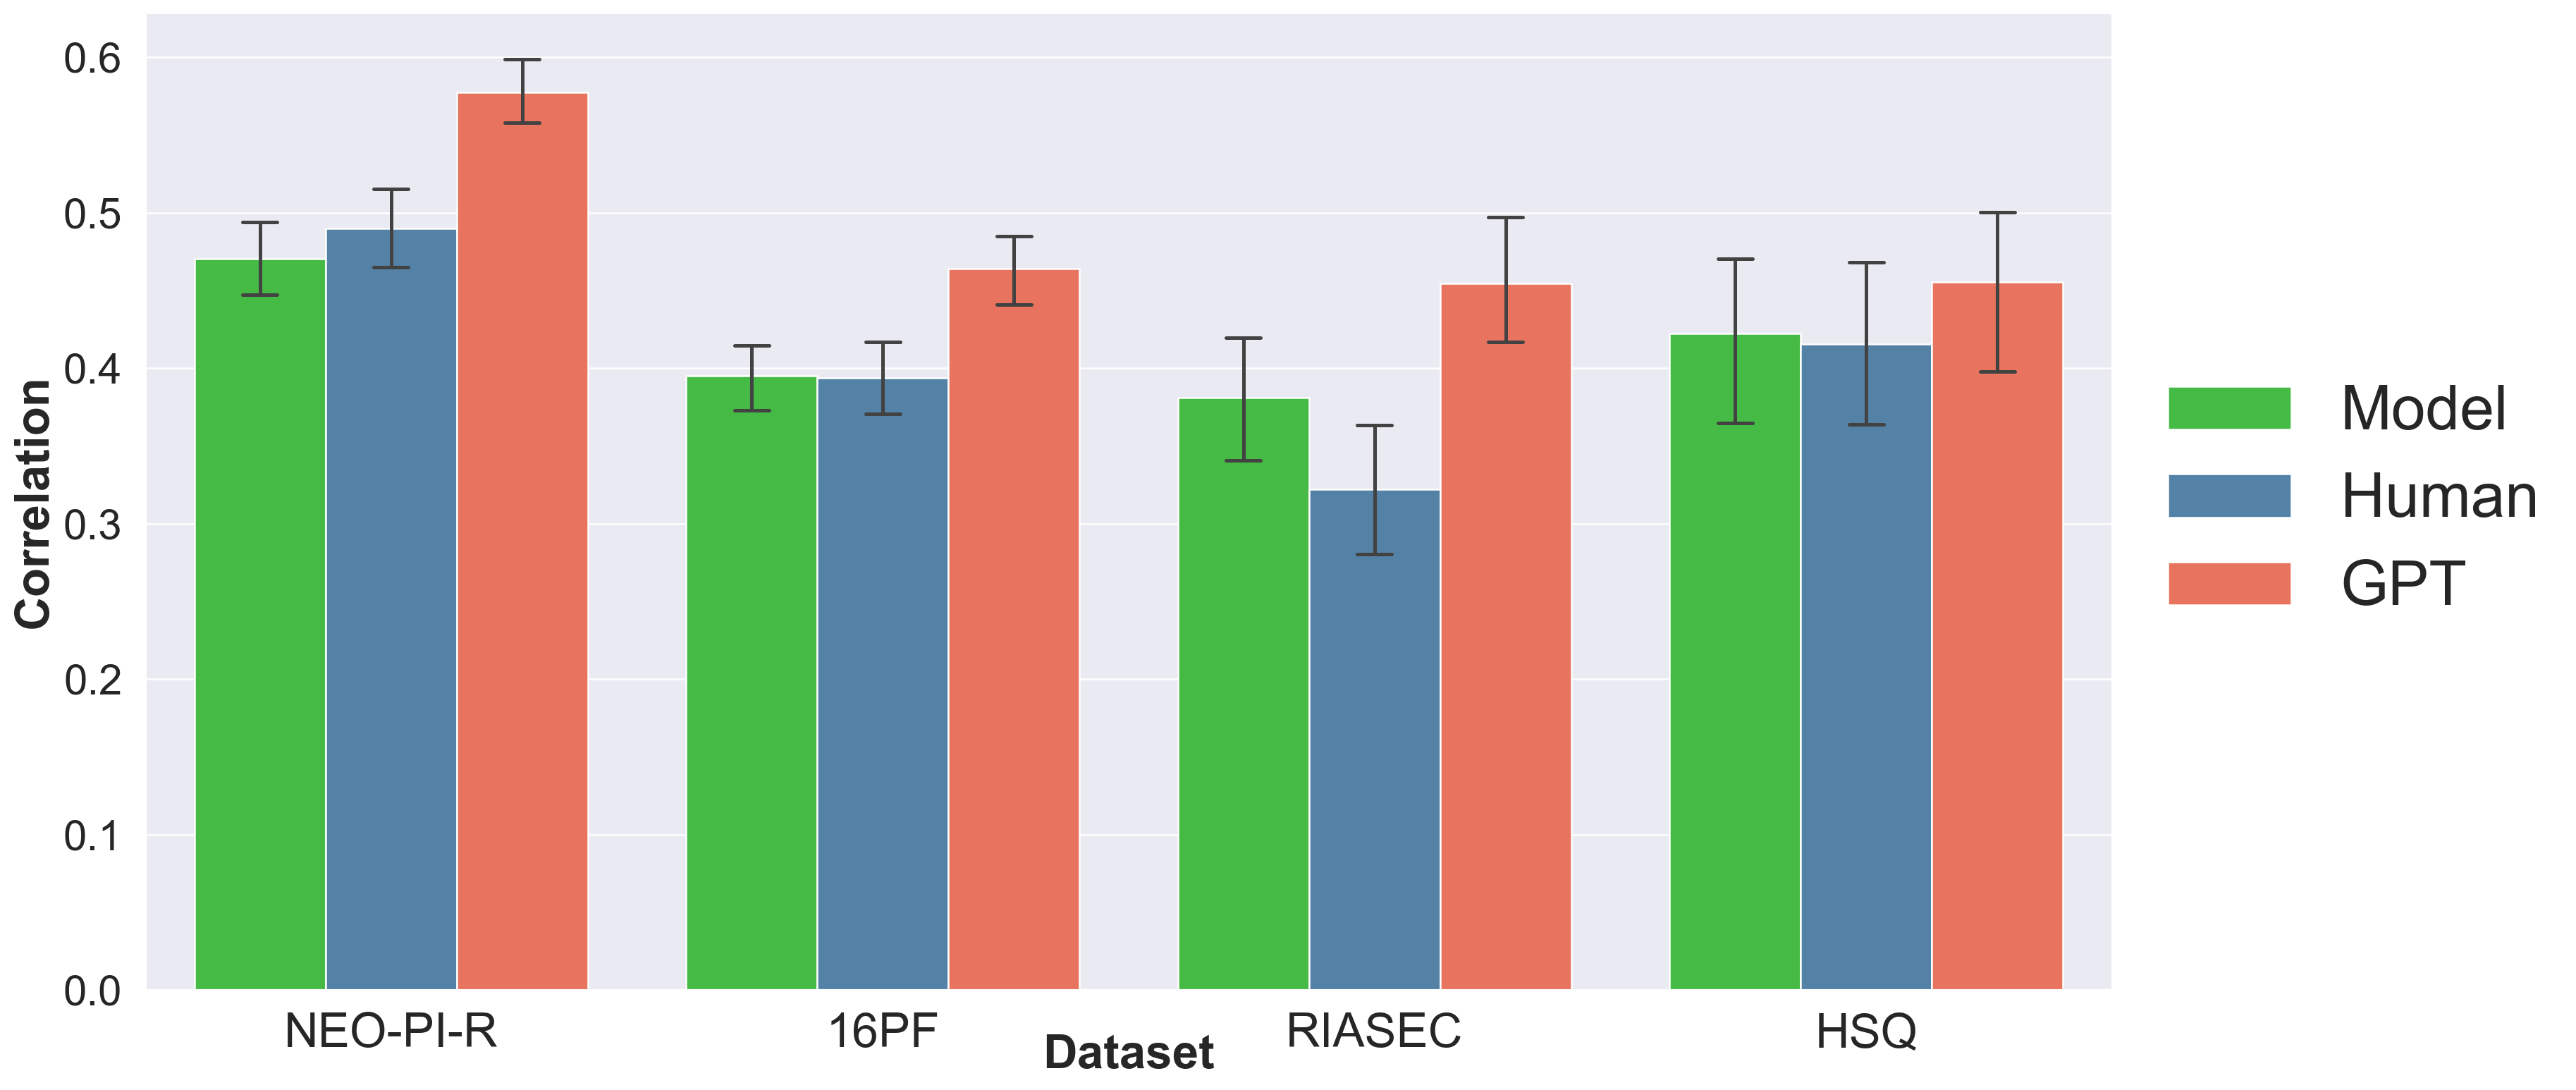

In [33]:
# prepare data: Add column to indicate the questionnaire/data -> combine all questionnaires into one dataset
df_comparisons_combined = pd.concat(df_comparisons, ignore_index=True)

#update font size, etc
plt.style.use("seaborn-v0_8")
sns.set_context('paper')
sns.set(font_scale = 1.4)
palette = ["limegreen","steelblue", "tomato"]

# Barplots: average performance across all targets (model vs human)
fig = plt.figure(figsize=(20, 10), dpi= 180)
sns.barplot(data=df_comparisons_combined, x="Dataset", y="Correlation", hue="Predictor", errorbar=('ci', 95), palette=palette, capsize=0.07, errwidth=2)
plt.ylabel("Correlation", fontweight='bold', fontsize=27)
plt.xlabel("Dataset", fontweight='bold', fontsize=27, labelpad=-13)
plt.xticks(fontsize=27)
plt.yticks(fontsize=24)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize="35")    

#save figures
fig_name = "fig4_gpt.pdf"
plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')
# fig_name = "fig4.tiff"
# plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')

### Distribution Plots

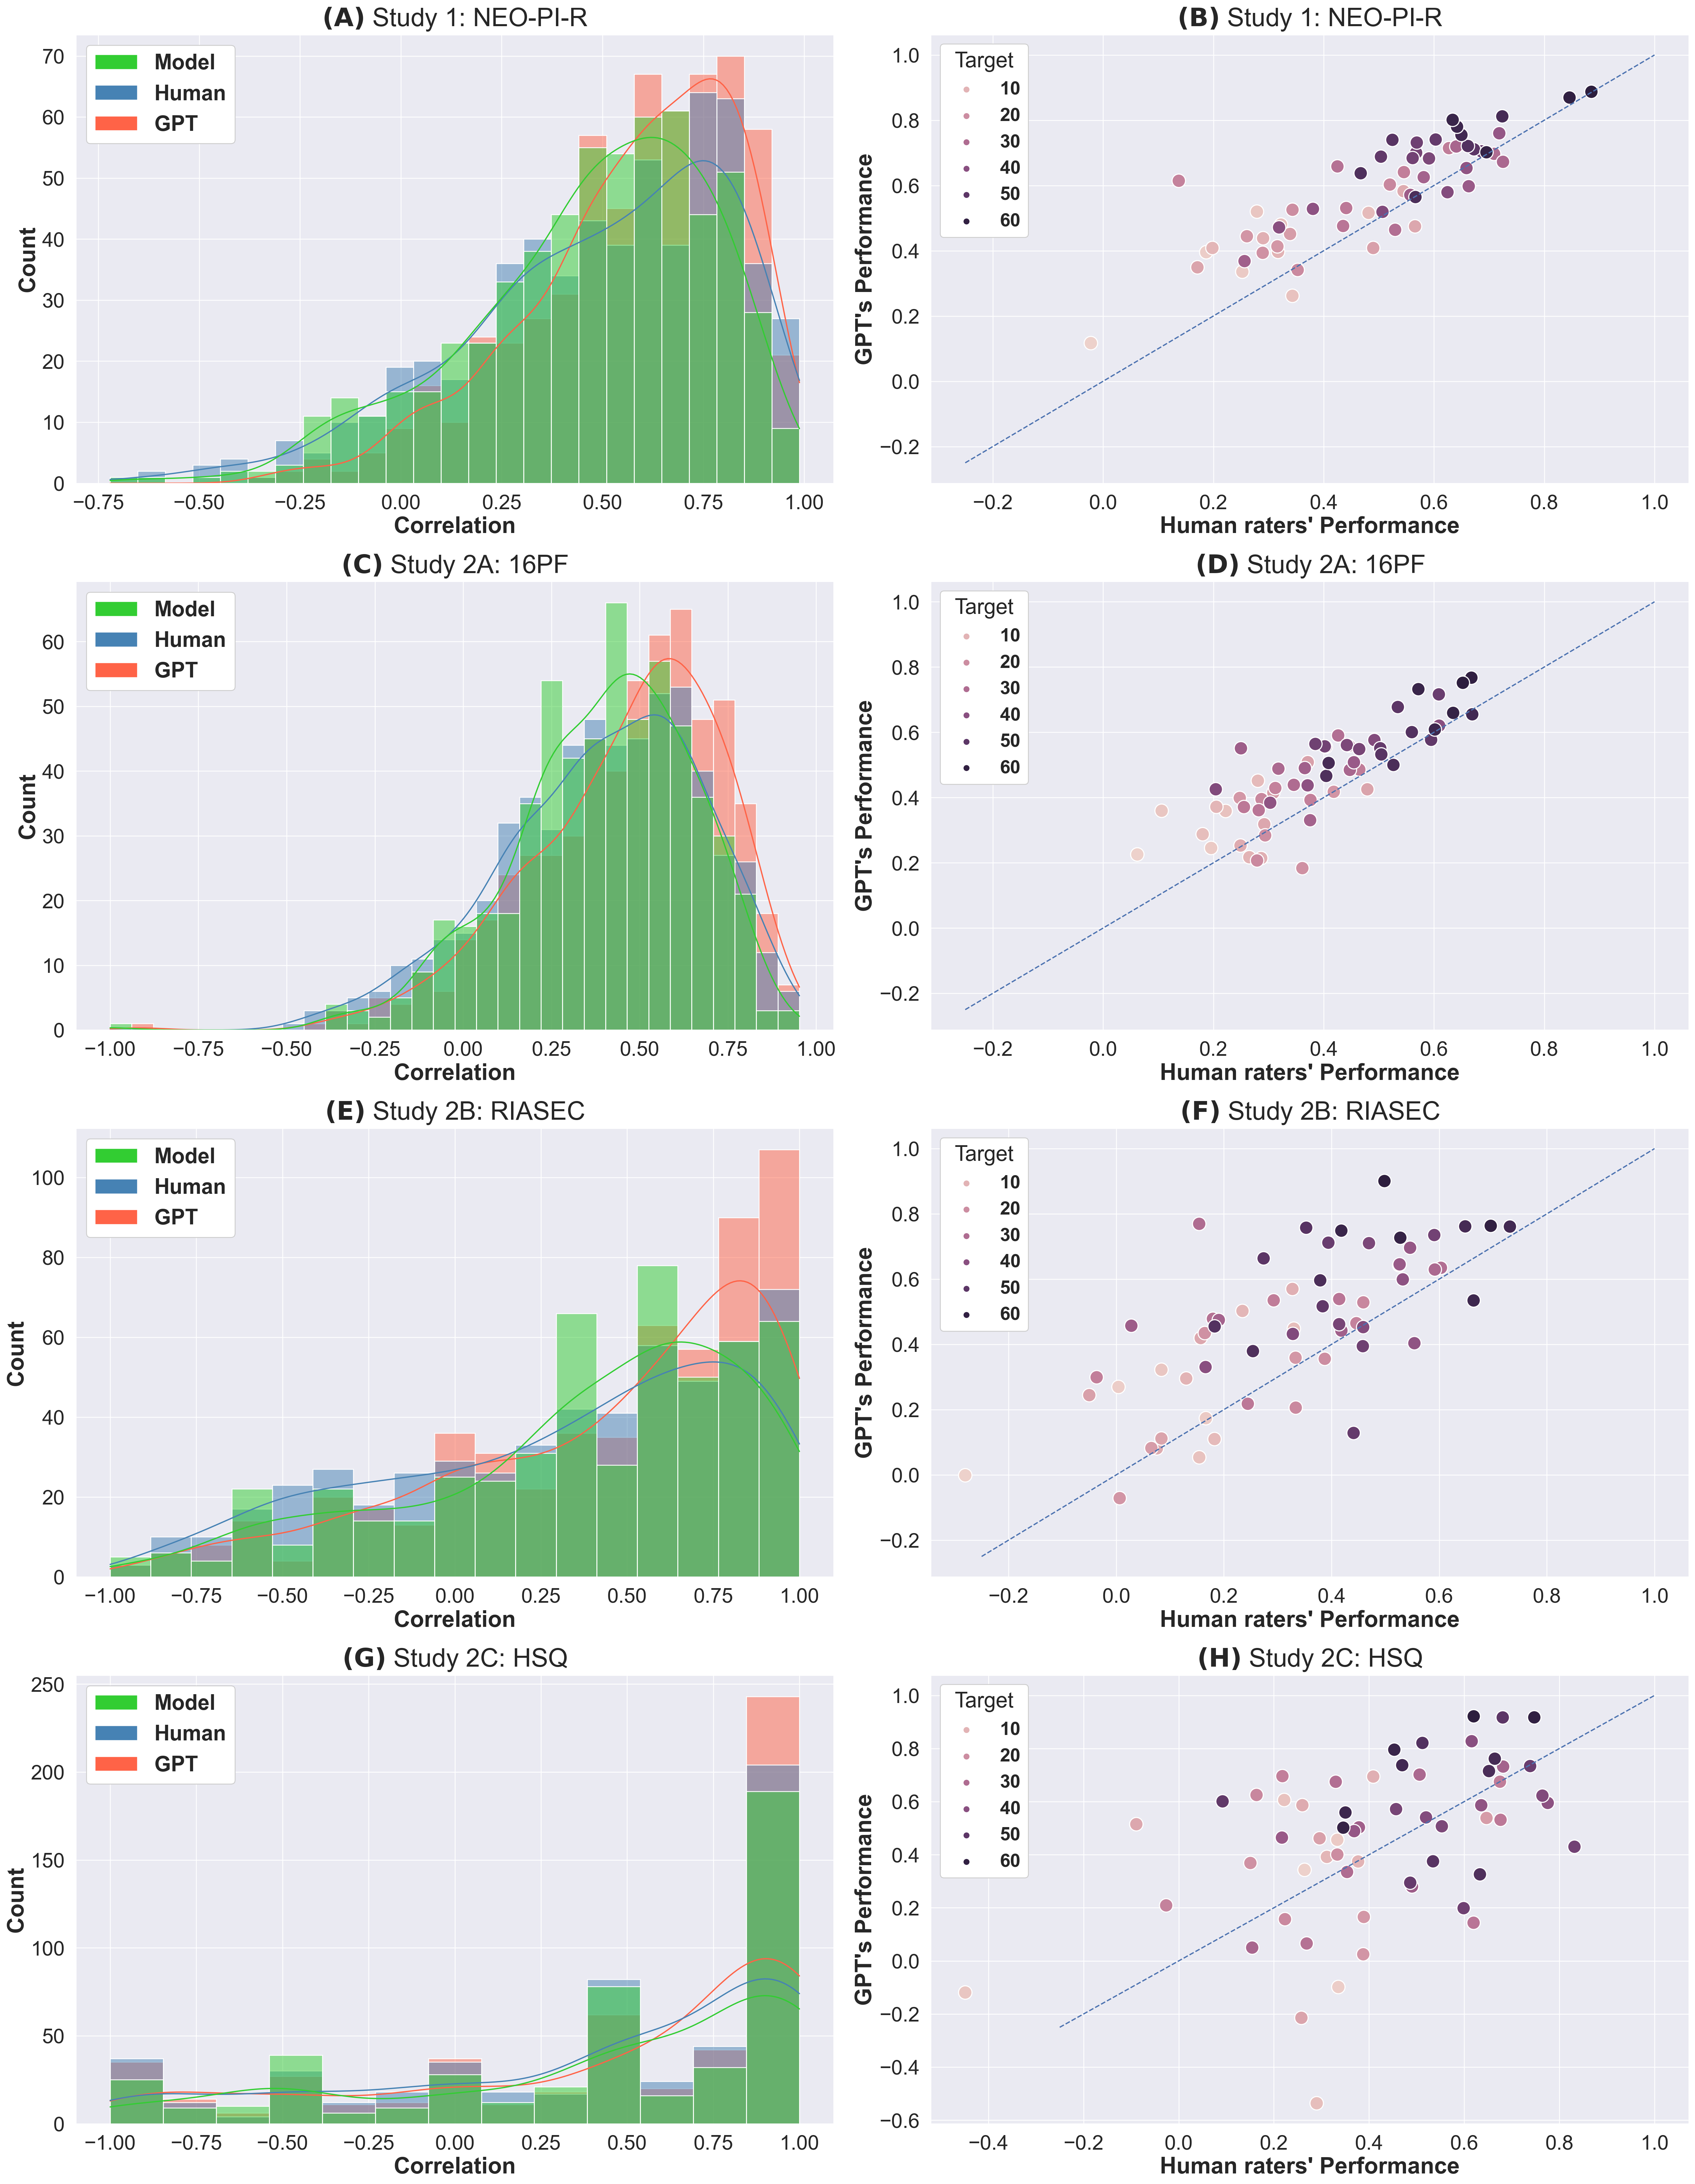

In [38]:
dataset_names = ["Study 1: NEO-PI-R", 'Study 2A: 16PF', 'Study 2B: RIASEC', 'Study 2C: HSQ']

fig = plt.figure(figsize=(28, 36), dpi= 180)
fig.subplots_adjust(hspace=0.35, wspace=0.2)

palette=["limegreen","steelblue", "tomato"]
handles = [Patch(facecolor=item) for item in palette]
alpha = list('abcdefghijklmnopqrstuvwxyz')

#update font size, etc
plt.style.use("seaborn-v0_8")
sns.set_context('paper')
sns.set(font_scale = 1.4)
    
for i in range(len(dataset_names)): #creates figures starting after big5: numbering starts at fig_*_C
    df_comparison = df_comparisons[i] #get data for each questionnaire

    #Add the distribution plots for each data set:
    ax = fig.add_subplot(4, 2, 2*(i)+1)
    sns.histplot(df_comparison, x="Correlation", kde=True, hue="Predictor", palette = palette, ax=ax)
    labels = df_comparison.Predictor.unique().tolist()
    ax.legend(loc = "upper left", handles = handles, labels = labels, frameon = True, framealpha = 1.0, facecolor='white',  prop={'weight':'bold', "size":25})
    ax.set_ylabel('Count', fontweight = "bold", fontsize = 27)
    ax.set_xlabel('Correlation', fontweight = "bold", fontsize = 27)
    plt.title(r"$\bf{(" + alpha[2*i].upper() + ")}$ " + dataset_names[i], fontsize=30, pad=10)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    # Prepare data for scatter plots: Plot model average performance over human average performance on each target
    df = df_comparison.loc[:, ["target", "Predictor", "Correlation"]] .groupby(["target", "Predictor"], as_index=False).aggregate("mean")
    df_scatter = df.pivot(index="target", columns='Predictor', values='Correlation').rename_axis(None, axis=1).reset_index()

    # Scatter plots
    ax = fig.add_subplot(4, 2, 2*(i)+2)
    sns.scatterplot(data=df_scatter, x="Human", y="GPT", hue="target", s=250, alpha=1.0, ax=ax)
    ax.set_ylabel('GPT\'s Performance', fontweight = "bold", fontsize=27)
    ax.set_xlabel('Human raters\' Performance', fontweight = "bold", fontsize=27)
    ax.legend(loc="upper left", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold','size':22}, title="Target", title_fontsize=25)
    ax.plot((-0.25, 1),(-0.25, 1), ls='--')
    plt.title(r"$\bf{(" + alpha[2*i+1].upper() + ")}$ " + dataset_names[i], fontsize=30, pad=10)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
#save figures
fig_name = "fig5_gpt.pdf" #update figure name 
plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')
# fig_name = "fig5.tiff" #update figure name 
# plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')

plt.tight_layout()
plt.show()

Merged all plots

In [37]:
dataset_names = ["Study 1: NEO-PI-R", 'Study 2A: 16PF', 'Study 2B: RIASEC', 'Study 2C: HSQ']

fig = plt.figure(figsize=(44, 36), dpi= 180)
fig.subplots_adjust(hspace=0.35, wspace=0.2)

palette=["limegreen","steelblue", "tomato"]
handles = [Patch(facecolor=item) for item in palette]
alpha = list('abcdefghijklmnopqrstuvwxyz')

#update font size, etc
plt.style.use("seaborn-v0_8")
sns.set_context('paper')
sns.set(font_scale = 1.4)
    
for i in range(len(dataset_names)): #creates figures starting after big5: numbering starts at fig_*_C
    df_comparison = df_comparisons[i] #get dataframe
    
    # Bar plots: average correlations (model vs humans)
    ax = fig.add_subplot(4, 3, 3*(i)+1)
    sns.barplot(y='Correlation', x='Predictor', orient='v', data=df_comparison, errorbar=('ci', 95), palette=palette, capsize=0.07, errwidth=2, ax=ax)
    plt.ylabel("Correlation", fontweight='bold', fontsize=27)
    plt.xlabel("", fontweight='bold', fontsize=27, labelpad=-13)
    plt.xticks(fontsize=27)
    plt.yticks(fontsize=24)
    plt.title(r"$\bf{(" + alpha[3*i].upper() + ")}$ " + dataset_names[i], fontsize=30, pad=10)
    
    # Distribution plots for each questionnaire:
    ax = fig.add_subplot(4, 3, 3*(i)+2)
    sns.histplot(df_comparison, x="Correlation", kde=True, hue="Predictor", palette = palette, ax=ax)
    labels = df_comparison.Predictor.unique().tolist()
    ax.legend(loc = "upper left", handles = handles, labels = labels, frameon = True, framealpha = 1.0, facecolor='white',  prop={'weight':'bold', "size":25})
    ax.set_ylabel('Count', fontweight = "bold", fontsize = 27)
    ax.set_xlabel('Correlation', fontweight = "bold", fontsize = 27)
    plt.title(r"$\bf{(" + alpha[3*i+1].upper() + ")}$ " + dataset_names[i], fontsize=30, pad=10)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    # Prepare data for scatter plots: Plot model average performance over human average performance on each target
    df = df_comparison.loc[:, ["target", "Predictor", "Correlation"]] .groupby(["target", "Predictor"], as_index=False).aggregate("mean")
    df_scatter = df.pivot(index="target", columns='Predictor', values='Correlation').rename_axis(None, axis=1).reset_index()

    # Scatter plots
    ax = fig.add_subplot(4, 3, 3*(i)+3)
    sns.scatterplot(data=df_scatter, x="Human", y="GPT", hue="target", s=250, alpha=1.0, ax=ax)
    ax.set_ylabel('GPT\'s Performance', fontweight = "bold", fontsize=27)
    ax.set_xlabel('Human raters\' Performance', fontweight = "bold", fontsize=27)
    ax.legend(loc="upper left", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold','size':22}, title="Target", title_fontsize=25)
    ax.plot((-0.25, 1),(-0.25, 1), ls='--')
    plt.title(r"$\bf{(" + alpha[3*i+2].upper() + ")}$ " + dataset_names[i], fontsize=30, pad=10)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
#save figures
fig_name = "fig5_unified.pdf" #update figure name (to skip 3rd number)
# plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')
# fig_name = "fig5_unified.tiff" #update figure name (to skip 3rd number)
# plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')

plt.tight_layout()
plt.show()

PearsonRResult(statistic=0.4535942116095687, pvalue=0.00030855618492685934)

In [49]:
pearsonr(df_pearsonr.Human, df_pearsonr.Model)

PearsonRResult(statistic=0.6992821594860221, pvalue=7.247033378583878e-10)